Photon by photon hidden Markov modeling scripts, when using this sofware, cite <br>
Pirchi et. al. Journal of Physical Chemistry B, 2016, 120, 13065-13075

Software was originally written in matlab, by Pirchi, and has been addapted to
python by Paul David Harris, please cite:<br>[![DOI](https://zenodo.org/badge/302447110.svg)](https://zenodo.org/badge/latestdoi/302447110)

In [1]:
import numpy as np
import os
import time
from numpy.linalg import matrix_power
from fretbursts import *
from H2MM import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


# Fetching and Analyzing Burst data

Perfect, I found the file!


data_minus8TA_minus6NTD_RPo_T25C_G150uW_R100uW_1 G1.000

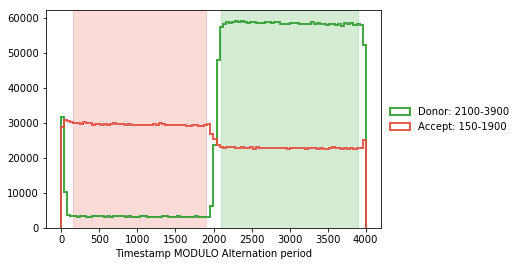

In [2]:
#url = 'http://files.figshare.com/9302599/minus8TA_minus6NTD_RPo_T25C_G150uW_R100uW_1.hdf5'
#download_file(url, save_dir='./data')
filename = '/home/paul/Documents/FRETBursts_notebooks-master/data/minus8TA_minus6NTD_RPo_T25C_G150uW_R100uW_1.hdf5'
if os.path.isfile(filename):
    print('Perfect, I found the file!')
else:
    print('ERROR: file does not exist')
d = loader.photon_hdf5(filename)
d.add(det_donor_accept=(0, 1), 
      alex_period=4000, 
      D_ON=(2100, 3900), 
      A_ON=(150, 1900),
      offset=700)
bpl.plot_alternation_hist (d)
loader.usalex_apply_period(d)

 - Calculating BG rates ... [DONE]


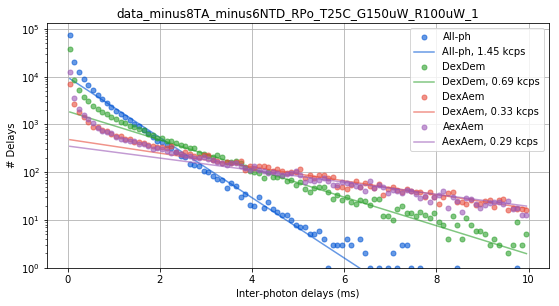

In [3]:
d.calc_bg(fun=bg.exp_fit,time_s=50.1, tail_min_us='auto', F_bg=1.7)

dplot(d, hist_bg)

/home/paul/anaconda3/envs/Py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3461: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/paul/anaconda3/envs/Py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


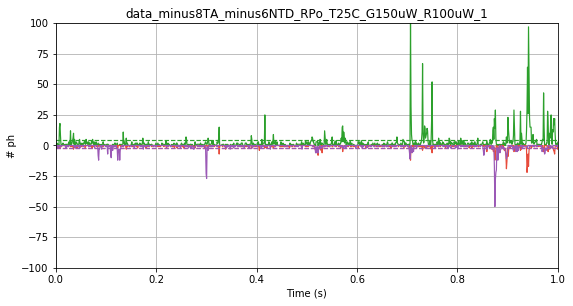

In [4]:
dplot(d, timetrace)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 14017 bursts (23.7%, 10 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


/home/paul/anaconda3/envs/Py37/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


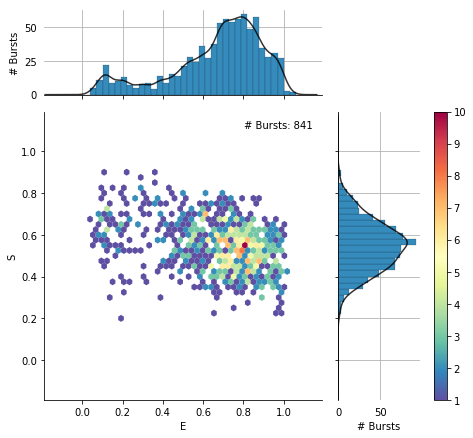

In [5]:
d.burst_search(m=10, F=6, ph_sel=Ph_sel(Dex='DAem'))
d.fuse_bursts(ms=0)
d_all = Sel(d, select_bursts.naa, th1=50)
d_all = Sel(d_all, select_bursts.size, th1=50)

alex_jointplot(d_all)

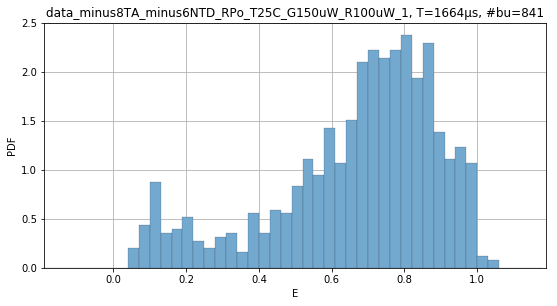

In [6]:
dplot(d_all, hist_fret)

# H2MM Analysis

First the bursts are separated into lists of arrival times and colors, which are then submitted to the EM_H2MM algorithm

In [7]:
print('Defining photon masks')
DAemDex_mask = d_all.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))
AemDex_mask = d_all.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))
AemDex_mask_red = AemDex_mask[DAemDex_mask]

d_all_bursts = d_all.mburst[0]
ph_d = d_all.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
print('Reducing photon burst indexes')
burst_red = d_all_bursts.recompute_index_reduce(ph_d)

TotalArrivalTime = np.empty([1,0], dtype=int)
ArrivalTime = []
ArrivalColor = []

nphot = 0
print('Separating data into bursts')
for start, stop in zip(burst_red.istart, burst_red.istop+1):
    ArrivalTime.append(ph_d[start:stop])
    ArrivalMask_temp = AemDex_mask_red[start:stop]
    ArrivalColor_temp = np.zeros(ArrivalMask_temp.size,dtype=int)
    ArrivalColor_temp[ArrivalMask_temp] = 1
    ArrivalColor.append(ArrivalColor_temp)
    nphot += ArrivalColor_temp.size
print(f'Number of bursts: {burst_red.num_bursts}, Number of Photons: {nphot}')

Defining photon masks
Reducing photon burst indexes
Separating data into bursts
Number of bursts: 841, Number of Photons: 119426


In [8]:
prior1 = np.array([1])
trans1 = np.array([[1]])
obs1 = np.array([[0.7,0.3]])
h_mod1i = h2mm_model(prior1,trans1,obs1)

h_mod1 = EM_H2MM_par(h_mod1i,ArrivalColor,ArrivalTime)

Begin compute_ess_dhmm
Iteration 0, loglik -104699.8058297677, iteration time 2.227728521975223, total time 2.227728521975223
Iteration 1, loglik -79662.83824285874, iteration time 2.11858857300831, total time 4.346317094983533
Converged


Now the 2 state model is defined and optimized

In [9]:
prior2 = np.array([0.1, 0.9])
trans2 = np.array([[0.998, 0.002],[0.0001, 0.9999]])
obs2 = np.array([[0.3, 0.7],[0.8, 0.2]])
h_mod2i = h2mm_model(prior2,trans2,obs2)

h_mod2 = EM_H2MM_par(h_mod2i,ArrivalColor,ArrivalTime)

Begin compute_ess_dhmm
Iteration 0, loglik -115494.49841480485, iteration time 4.299464743002318, total time 4.299464743002318
Iteration 1, loglik -79541.99722324774, iteration time 4.1706324690021574, total time 8.470097212004475
Iteration 2, loglik -78768.26979295402, iteration time 3.9897799469763413, total time 12.459877158980817
Iteration 3, loglik -78661.85470154302, iteration time 4.0515356180258095, total time 16.511412777006626
Iteration 4, loglik -78572.57033182203, iteration time 3.920820020022802, total time 20.432232797029428
Iteration 5, loglik -78490.9672973547, iteration time 3.946387917967513, total time 24.37862071499694
Iteration 6, loglik -78412.9019610773, iteration time 3.897388690034859, total time 28.2760094050318
Iteration 7, loglik -78335.2654634434, iteration time 3.9924880969920196, total time 32.26849750202382
Iteration 8, loglik -78255.83100281446, iteration time 3.8625422539771535, total time 36.13103975600097
Iteration 9, loglik -78173.00243242807, itera

Iteration 79, loglik -70548.92027135336, iteration time 3.8676650549750775, total time 323.41089381900383
Iteration 80, loglik -70446.49109426224, iteration time 3.8916636690264568, total time 327.3025574880303
Iteration 81, loglik -70343.60004722272, iteration time 3.933603191981092, total time 331.2361606800114
Iteration 82, loglik -70240.01488352139, iteration time 3.9141466399887577, total time 335.15030732000014
Iteration 83, loglik -70135.520745004, iteration time 3.911615189979784, total time 339.0619225099799
Iteration 84, loglik -70029.92368498309, iteration time 3.984575222013518, total time 343.04649773199344
Iteration 85, loglik -69923.0536665553, iteration time 3.889187964028679, total time 346.9356856960221
Iteration 86, loglik -69814.76710621791, iteration time 3.91694488999201, total time 350.85263058601413
Iteration 87, loglik -69704.94903064174, iteration time 3.8648293539881706, total time 354.7174599400023
Iteration 88, loglik -69593.51491680546, iteration time 3.86

Iteration 157, loglik -66259.53585166045, iteration time 3.966021793021355, total time 630.0236370450002
Iteration 158, loglik -66259.53548367143, iteration time 3.8397194650024176, total time 633.8633565100026
Iteration 159, loglik -66259.53522086302, iteration time 3.8786540720029734, total time 637.7420105820056
Iteration 160, loglik -66259.53503327118, iteration time 3.903988901991397, total time 641.645999483997
Iteration 161, loglik -66259.53489942534, iteration time 4.29319450998446, total time 645.9391939939815
Iteration 162, loglik -66259.534803877, iteration time 4.339732812019065, total time 650.2789268060005
Iteration 163, loglik -66259.53473577264, iteration time 4.0917238860274665, total time 654.370650692028
Iteration 164, loglik -66259.53468717828, iteration time 3.9359125249902718, total time 658.3065632170183
Iteration 165, loglik -66259.53465255797, iteration time 3.861349855957087, total time 662.1679130729754
Iteration 166, loglik -66259.53462784801, iteration time

Now with a 3-state model

In [10]:
prior3 = np.array([0.3, 0.5, 0.2])
trans3 = np.array([[0.9998, 0.0001, 0.0001],[0.00001, 0.99998, 0.00001],[0.000001, 0.000001, 0.999998]])
obs3 = np.array([[0.1, 0.9],[0.2, 0.8],[0.3, 0.7]])
h_mod3i = h2mm_model(prior3,trans3,obs3)

h_mod3 = EM_H2MM_par(h_mod3i,ArrivalColor,ArrivalTime)

Begin compute_ess_dhmm
Iteration 0, loglik -80914.62626838054, iteration time 12.739315919985529, total time 12.739315919985529
Iteration 1, loglik -71576.24379428661, iteration time 12.709684198023751, total time 25.44900011800928
Iteration 2, loglik -68417.5262573175, iteration time 12.863147213007323, total time 38.312147331016604
Iteration 3, loglik -67251.99445499513, iteration time 12.821773741976358, total time 51.13392107299296
Iteration 4, loglik -66704.8407602547, iteration time 12.78990575298667, total time 63.92382682597963
Iteration 5, loglik -66437.94804833907, iteration time 12.877625827037264, total time 76.8014526530169
Iteration 6, loglik -66305.96250131879, iteration time 12.75003489095252, total time 89.55148754396942
Iteration 7, loglik -66238.55061806468, iteration time 12.833069804008119, total time 102.38455734797753
Iteration 8, loglik -66199.64604530197, iteration time 12.84655548504088, total time 115.23111283301841
Iteration 9, loglik -66171.00002224073, ite

Iteration 78, loglik -64617.603903572795, iteration time 12.710477044980507, total time 975.7441676519811
Iteration 79, loglik -64617.19120897992, iteration time 12.926061498001218, total time 988.6702291499823
Iteration 80, loglik -64616.82954651176, iteration time 12.651825188018847, total time 1001.3220543380012
Iteration 81, loglik -64616.51268748697, iteration time 12.664248845016118, total time 1013.9863031830173
Iteration 82, loglik -64616.23510393444, iteration time 12.702984177973121, total time 1026.6892873609904
Iteration 83, loglik -64615.99190457222, iteration time 12.671139061974827, total time 1039.3604264229652
Iteration 84, loglik -64615.77877275559, iteration time 12.636662931006867, total time 1051.9970893539721
Iteration 85, loglik -64615.59190913466, iteration time 12.671940827043727, total time 1064.6690301810158
Iteration 86, loglik -64615.427976344545, iteration time 12.77153859398095, total time 1077.4405687749968
Iteration 87, loglik -64615.28404910954, iterat

Iteration 155, loglik -64614.0796026397, iteration time 12.812778205028735, total time 1949.2692080800189
Iteration 156, loglik -64614.0790135288, iteration time 13.035345016978681, total time 1962.3045530969976
Iteration 157, loglik -64614.07845782488, iteration time 12.693709928018507, total time 1974.998263025016
Iteration 158, loglik -64614.077933533765, iteration time 12.656017913948745, total time 1987.6542809389648
Iteration 159, loglik -64614.07743887135, iteration time 12.614055557001848, total time 2000.2683364959667
Iteration 160, loglik -64614.07697208805, iteration time 12.640791045036167, total time 2012.9091275410028
Iteration 161, loglik -64614.076531632476, iteration time 12.520213186973706, total time 2025.4293407279765
Iteration 162, loglik -64614.076116014214, iteration time 12.723699942987878, total time 2038.1530406709644
Iteration 163, loglik -64614.075723764785, iteration time 12.808757452003192, total time 2050.9617981229676
Iteration 164, loglik -64614.0753536

Iteration 232, loglik -64614.06918981028, iteration time 12.017648564011324, total time 2891.458181287977
Iteration 233, loglik -64614.06918218179, iteration time 12.130054050998297, total time 2903.588235338975
Iteration 234, loglik -64614.06917498831, iteration time 11.874269586987793, total time 2915.462504925963
Iteration 235, loglik -64614.06916816734, iteration time 12.391690563003067, total time 2927.854195488966
Iteration 236, loglik -64614.06916169942, iteration time 12.49109139101347, total time 2940.3452868799795
Iteration 237, loglik -64614.06915560672, iteration time 12.107869188999757, total time 2952.4531560689793
Iteration 238, loglik -64614.06914978613, iteration time 12.038147232029587, total time 2964.491303301009
Iteration 239, loglik -64614.06914431161, iteration time 12.124112452962436, total time 2976.6154157539713
Iteration 240, loglik -64614.06913910328, iteration time 12.44062362704426, total time 2989.0560393810156
Iteration 241, loglik -64614.06913420021, it

Iteration 310, loglik -64614.06904827038, iteration time 12.596504078013822, total time 3871.9396767499857
Iteration 311, loglik -64614.06904817663, iteration time 12.315598463988863, total time 3884.2552752139745
Iteration 312, loglik -64614.069048076824, iteration time 12.84579496801598, total time 3897.1010701819905
Iteration 313, loglik -64614.069047996236, iteration time 12.350834261975251, total time 3909.4519044439658
Iteration 314, loglik -64614.06904786941, iteration time 12.79673627804732, total time 3922.248640722013
Iteration 315, loglik -64614.06904780421, iteration time 12.352023712999653, total time 3934.6006644350127
Iteration 316, loglik -64614.06904770798, iteration time 12.349510667962022, total time 3946.9501751029748
Iteration 317, loglik -64614.06904764948, iteration time 12.401435534993652, total time 3959.3516106379684
Iteration 318, loglik -64614.06904755975, iteration time 12.449002828041557, total time 3971.80061346601
Iteration 319, loglik -64614.06904749004

Calculate 4 state model

In [11]:
prior4 = np.array([0.25,0.25,0.25,0.25])
trans4 = np.array([[0.99996,0.00001,0.00001,0.00001],[0.00001,0.99996,0.00001,0.00001],[0.00001,0.00001,0.99996,0.00001],[0.00001,0.00001,0.00001,0.99996]])
obs4 = np.array([[0.2,0.8],[0.4,0.6],[0.6,0.4],[0.8,0.2]])
h_mod4i = h2mm_model(prior4,trans4,obs4)

h_mod4 = EM_H2MM_par(h_mod4i,ArrivalColor,ArrivalTime)

Begin compute_ess_dhmm
Iteration 0, loglik -72811.33615359325, iteration time 55.56248120497912, total time 55.56248120497912
Iteration 1, loglik -65391.995071777455, iteration time 54.417695127020124, total time 109.98017633199925
Iteration 2, loglik -65098.74004232722, iteration time 54.44584348599892, total time 164.42601981799817
Iteration 3, loglik -64976.06339678567, iteration time 54.233208767022006, total time 218.65922858502017
Iteration 4, loglik -64878.012790733716, iteration time 55.245591562008485, total time 273.90482014702866
Iteration 5, loglik -64791.24710133783, iteration time 53.95523986394983, total time 327.8600600109785
Iteration 6, loglik -64714.23474957237, iteration time 54.27718452102272, total time 382.1372445320012
Iteration 7, loglik -64646.51936488564, iteration time 53.836207234009635, total time 435.97345176601084
Iteration 8, loglik -64587.72278538405, iteration time 53.25878538901452, total time 489.23223715502536
Iteration 9, loglik -64537.41308988018

Iteration 79, loglik -64273.30968717449, iteration time 53.77295403298922, total time 4374.822520177986
Iteration 80, loglik -64272.656009853315, iteration time 56.51582599803805, total time 4431.338346176024
Iteration 81, loglik -64272.00842373633, iteration time 55.80382904299768, total time 4487.142175219022
Iteration 82, loglik -64271.36680011823, iteration time 56.1826721499674, total time 4543.324847368989
Iteration 83, loglik -64270.73101854967, iteration time 58.88504352100426, total time 4602.209890889993
Iteration 84, loglik -64270.100966806225, iteration time 55.44264112098608, total time 4657.6525320109795
Iteration 85, loglik -64269.476540493975, iteration time 55.98514667805284, total time 4713.637678689032
Iteration 86, loglik -64268.857642752264, iteration time 54.648408542969264, total time 4768.286087232002
Iteration 87, loglik -64268.24418388523, iteration time 55.15725337801268, total time 4823.443340610014
Iteration 88, loglik -64267.63608141237, iteration time 55.

Iteration 158, loglik -64237.01389722972, iteration time 60.43174294801429, total time 8793.12849030702
Iteration 159, loglik -64236.73968698641, iteration time 60.23950375401182, total time 8853.367994061031
Iteration 160, loglik -64236.469619079064, iteration time 61.1940822309698, total time 8914.562076292
Iteration 161, loglik -64236.20365633193, iteration time 60.365101139992476, total time 8974.927177431993
Iteration 162, loglik -64235.941760717615, iteration time 58.96523812500527, total time 9033.892415556998
Iteration 163, loglik -64235.68389362589, iteration time 58.88543112803018, total time 9092.777846685029
Iteration 164, loglik -64235.430015511585, iteration time 58.460238784959074, total time 9151.238085469988
Iteration 165, loglik -64235.18008630915, iteration time 57.05330565501936, total time 9208.291391125007
Iteration 166, loglik -64234.93406532088, iteration time 55.40795831201831, total time 9263.699349437025
Iteration 167, loglik -64234.691911244576, iteration ti

Iteration 236, loglik -64224.859222306586, iteration time 58.73951023200061, total time 13404.01372354501
Iteration 237, loglik -64224.784314690376, iteration time 59.140603702981025, total time 13463.15432724799
Iteration 238, loglik -64224.71060416103, iteration time 60.0326737560099, total time 13523.187001004
Iteration 239, loglik -64224.638068368586, iteration time 59.96010160102742, total time 13583.147102605028
Iteration 240, loglik -64224.566685272875, iteration time 58.13973198499298, total time 13641.28683459002
Iteration 241, loglik -64224.49643331501, iteration time 60.16791037598159, total time 13701.454744966002
Iteration 242, loglik -64224.42729139799, iteration time 58.919305228977464, total time 13760.37405019498
Iteration 243, loglik -64224.359238741206, iteration time 58.57294473500224, total time 13818.946994929982
Iteration 244, loglik -64224.29225503339, iteration time 59.83424691302935, total time 13878.781241843011
Iteration 245, loglik -64224.22632037388, itera

Iteration 314, loglik -64221.396183575285, iteration time 57.786877587030176, total time 17932.16247232101
Iteration 315, loglik -64221.371813957645, iteration time 57.12026474799495, total time 17989.282737069007
Iteration 316, loglik -64221.347757160765, iteration time 57.97941992001142, total time 18047.262156989018
Iteration 317, loglik -64221.3240084622, iteration time 56.462915871001314, total time 18103.72507286002
Iteration 318, loglik -64221.30056324888, iteration time 57.14572397398297, total time 18160.870796834002
Iteration 319, loglik -64221.27741702453, iteration time 56.95063031400787, total time 18217.82142714801
Iteration 320, loglik -64221.25456538648, iteration time 58.409965566010214, total time 18276.23139271402
Iteration 321, loglik -64221.23200393604, iteration time 57.958813779987395, total time 18334.190206494008
Iteration 322, loglik -64221.209728424714, iteration time 57.85681280301651, total time 18392.047019297024
Iteration 323, loglik -64221.187734691994, 

Iteration 392, loglik -64220.16986390485, iteration time 62.20114575495245, total time 22552.091884656984
Iteration 393, loglik -64220.16038154557, iteration time 63.282211687008385, total time 22615.374096343992
Iteration 394, loglik -64220.15100729116, iteration time 62.495760358986445, total time 22677.86985670298
Iteration 395, loglik -64220.141739894214, iteration time 64.05495030002203, total time 22741.924807003
Iteration 396, loglik -64220.13257795061, iteration time 63.113677648012526, total time 22805.038484651013
Iteration 397, loglik -64220.12352020095, iteration time 61.82563088298775, total time 22866.864115534
Iteration 398, loglik -64220.11456533026, iteration time 62.05893960001413, total time 22928.923055134015
Iteration 399, loglik -64220.10571206696, iteration time 62.88414387300145, total time 22991.807199007017
Iteration 400, loglik -64220.09695913419, iteration time 63.47436414996628, total time 23055.281563156983
Iteration 401, loglik -64220.088305369376, iterat

Iteration 470, loglik -64219.67432997774, iteration time 59.99750147899613, total time 27265.142315805017
Iteration 471, loglik -64219.67033766302, iteration time 58.8302456230158, total time 27323.972561428032
Iteration 472, loglik -64219.66638800484, iteration time 59.1233599409461, total time 27383.09592136898
Iteration 473, loglik -64219.66248070631, iteration time 59.54731880000327, total time 27442.64324016898
Iteration 474, loglik -64219.65861521172, iteration time 59.16553592903074, total time 27501.808776098012
Iteration 475, loglik -64219.654790941764, iteration time 58.21890048397472, total time 27560.027676581987
Iteration 476, loglik -64219.65100757109, iteration time 59.88591052003903, total time 27619.913587102026
Iteration 477, loglik -64219.64726457637, iteration time 58.31113006797386, total time 27678.22471717
Iteration 478, loglik -64219.64356154076, iteration time 58.22913232102292, total time 27736.453849491023
Iteration 479, loglik -64219.63989795855, iteration t

Iteration 548, loglik -64219.461474189164, iteration time 63.70646088098874, total time 32058.16332755302
Iteration 549, loglik -64219.45971908761, iteration time 62.12154213996837, total time 32120.284869692987
Iteration 550, loglik -64219.45798198474, iteration time 62.70834355003899, total time 32182.993213243026
Iteration 551, loglik -64219.45626276016, iteration time 61.03776384796947, total time 32244.030977090995
Iteration 552, loglik -64219.454561213744, iteration time 63.08539636898786, total time 32307.116373459983
Iteration 553, loglik -64219.45287700706, iteration time 62.67893322301097, total time 32369.795306682994
Iteration 554, loglik -64219.45121018605, iteration time 62.148339423991274, total time 32431.943646106985
Iteration 555, loglik -64219.449560410816, iteration time 62.405551756033674, total time 32494.34919786302
Iteration 556, loglik -64219.44792758358, iteration time 61.82182523299707, total time 32556.171023096016
Iteration 557, loglik -64219.44631149887, i

Iteration 626, loglik -64219.36666662868, iteration time 63.05722864199197, total time 36885.871237049985
Iteration 627, loglik -64219.36587250821, iteration time 63.753032464999706, total time 36949.624269514985
Iteration 628, loglik -64219.36508632003, iteration time 62.89920202502981, total time 37012.523471540015
Iteration 629, loglik -64219.364307931464, iteration time 63.009961812989786, total time 37075.533433353005
Iteration 630, loglik -64219.363537258694, iteration time 62.48085637699114, total time 37138.014289729996
Iteration 631, loglik -64219.36277434245, iteration time 61.44753695302643, total time 37199.46182668302
Iteration 632, loglik -64219.362018925574, iteration time 60.93540869699791, total time 37260.39723538002
Iteration 633, loglik -64219.36127106987, iteration time 61.6851665849681, total time 37322.08240196499
Iteration 634, loglik -64219.3605306591, iteration time 62.87020978203509, total time 37384.95261174702
Iteration 635, loglik -64219.35979755249, itera

Iteration 704, loglik -64219.323340853516, iteration time 60.18067986302776, total time 41670.34813715401
Iteration 705, loglik -64219.32297333408, iteration time 59.71410282800207, total time 41730.06223998201
Iteration 706, loglik -64219.32260944137, iteration time 60.98811864701565, total time 41791.05035862903
Iteration 707, loglik -64219.32224903852, iteration time 58.70619880600134, total time 41849.75655743503
Iteration 708, loglik -64219.32189212006, iteration time 59.126310386986006, total time 41908.882867822016
Iteration 709, loglik -64219.32153868275, iteration time 59.034495580999646, total time 41967.917363403016
Iteration 710, loglik -64219.321188609014, iteration time 58.12424617097713, total time 42026.04160957399
Iteration 711, loglik -64219.32084198729, iteration time 58.68726588500431, total time 42084.728875459
Iteration 712, loglik -64219.320498656605, iteration time 57.5789209450013, total time 42142.307796404
Iteration 713, loglik -64219.32015866017, iteration t

Iteration 782, loglik -64219.30310744699, iteration time 60.35393768601352, total time 46444.20404725801
Iteration 783, loglik -64219.30293371154, iteration time 59.46300402499037, total time 46503.667051283
Iteration 784, loglik -64219.30276155397, iteration time 60.23306011600653, total time 46563.90011139901
Iteration 785, loglik -64219.30259113908, iteration time 58.99244106101105, total time 46622.89255246002
Iteration 786, loglik -64219.3024221645, iteration time 57.85305051499745, total time 46680.74560297502
Iteration 787, loglik -64219.30225488525, iteration time 59.54529417201411, total time 46740.29089714703
Iteration 788, loglik -64219.30208915795, iteration time 60.144828410993796, total time 46800.435725558025
Iteration 789, loglik -64219.30192500677, iteration time 60.57763408799656, total time 46861.01335964602
Iteration 790, loglik -64219.30176234607, iteration time 57.52295676898211, total time 46918.536316415004
Iteration 791, loglik -64219.30160124184, iteration tim

Iteration 860, loglik -64219.293441400085, iteration time 60.35687073902227, total time 51042.12964341603
Iteration 861, loglik -64219.2933571492, iteration time 59.84685707098106, total time 51101.97650048701
Iteration 862, loglik -64219.29327367803, iteration time 58.84575204498833, total time 51160.822252532
Iteration 863, loglik -64219.293190943295, iteration time 59.428610799019225, total time 51220.25086333102
Iteration 864, loglik -64219.29310898323, iteration time 60.00219279999146, total time 51280.25305613101
Iteration 865, loglik -64219.29302772503, iteration time 60.47552270500455, total time 51340.72857883602
Iteration 866, loglik -64219.29294719269, iteration time 58.56108521501301, total time 51399.28966405103
Iteration 867, loglik -64219.29286745492, iteration time 60.47089908999624, total time 51459.760563141026
Iteration 868, loglik -64219.29278840072, iteration time 59.0856228210032, total time 51518.84618596203
Iteration 869, loglik -64219.29271001261, iteration tim

Iteration 938, loglik -64219.28868926595, iteration time 56.80323463201057, total time 55675.10727130901
Iteration 939, loglik -64219.288647003305, iteration time 54.90092892199755, total time 55730.00820023101
Iteration 940, loglik -64219.28860507068, iteration time 54.34050253400346, total time 55784.34870276501
Iteration 941, loglik -64219.288563529546, iteration time 58.32416648598155, total time 55842.67286925099
Iteration 942, loglik -64219.28852235794, iteration time 59.53196479502367, total time 55902.20483404602
Iteration 943, loglik -64219.288481507414, iteration time 58.69183769298252, total time 55960.896671739
Iteration 944, loglik -64219.28844101449, iteration time 59.30698350101011, total time 56020.20365524001
Iteration 945, loglik -64219.28840087141, iteration time 58.90767417900497, total time 56079.111329419015
Iteration 946, loglik -64219.2883610262, iteration time 59.695027929963544, total time 56138.80635734898
Iteration 947, loglik -64219.28832159248, iteration t

Iteration 1016, loglik -64219.28625748023, iteration time 60.26051095605362, total time 60310.62941892503
Iteration 1017, loglik -64219.28623523758, iteration time 59.28582135896431, total time 60369.915240284
Iteration 1018, loglik -64219.286213135485, iteration time 59.65105665498413, total time 60429.56629693898
Iteration 1019, loglik -64219.28619122812, iteration time 61.98300674004713, total time 60491.54930367903
Iteration 1020, loglik -64219.286169502666, iteration time 59.32427614496555, total time 60550.873579823994
Iteration 1021, loglik -64219.28614792896, iteration time 60.626177511003334, total time 60611.499757335
Iteration 1022, loglik -64219.28612654386, iteration time 59.36031991802156, total time 60670.86007725302
Iteration 1023, loglik -64219.28610532029, iteration time 58.996278931968845, total time 60729.85635618499
Iteration 1024, loglik -64219.286084230895, iteration time 59.69932841800619, total time 60789.555684602994
Iteration 1025, loglik -64219.286063324136,

Iteration 1093, loglik -64219.28495396335, iteration time 56.710560261970386, total time 64831.06091667799
Iteration 1094, loglik -64219.28494135455, iteration time 57.93815700500272, total time 64888.99907368299
Iteration 1095, loglik -64219.284928867186, iteration time 56.63154057302745, total time 64945.63061425602
Iteration 1096, loglik -64219.284916404904, iteration time 56.84830118197715, total time 65002.478915438
Iteration 1097, loglik -64219.28490409893, iteration time 56.56565375998616, total time 65059.044569197984
Iteration 1098, loglik -64219.28489185381, iteration time 57.13456298399251, total time 65116.17913218198
Iteration 1099, loglik -64219.28487966631, iteration time 57.52783872804139, total time 65173.70697091002
Iteration 1100, loglik -64219.28486757753, iteration time 57.213823055964895, total time 65230.92079396598
Iteration 1101, loglik -64219.28485554194, iteration time 58.43142835202161, total time 65289.352222318004
Iteration 1102, loglik -64219.284843670626

Iteration 1171, loglik -64219.284182683135, iteration time 59.45433209504699, total time 69644.22486910602
Iteration 1172, loglik -64219.28417503779, iteration time 59.42097867099801, total time 69703.64584777702
Iteration 1173, loglik -64219.284167401296, iteration time 59.69008661998669, total time 69763.33593439701
Iteration 1174, loglik -64219.2841598547, iteration time 59.483451106993016, total time 69822.819385504
Iteration 1175, loglik -64219.28415231409, iteration time 59.40187850600341, total time 69882.22126401
Iteration 1176, loglik -64219.28414484197, iteration time 58.941116911009885, total time 69941.16238092101
Iteration 1177, loglik -64219.284137343166, iteration time 58.54206430999329, total time 69999.70444523101
Iteration 1178, loglik -64219.28412995753, iteration time 57.54003106098389, total time 70057.24447629199
Iteration 1179, loglik -64219.28412257608, iteration time 58.10654961102409, total time 70115.35102590302
Iteration 1180, loglik -64219.28411528635, iter

Iteration 1249, loglik -64219.28369455773, iteration time 58.72609334997833, total time 74448.57887414098
Iteration 1250, loglik -64219.28368950443, iteration time 66.46165594604099, total time 74515.04053008702
Iteration 1251, loglik -64219.28368443487, iteration time 69.87386431696359, total time 74584.91439440398
Iteration 1252, loglik -64219.283679419, iteration time 68.49913166003535, total time 74653.41352606402
Iteration 1253, loglik -64219.283674387036, iteration time 68.04555656696903, total time 74721.45908263099
Iteration 1254, loglik -64219.283669403965, iteration time 67.53577994403895, total time 74788.99486257503
Iteration 1255, loglik -64219.28366447783, iteration time 66.75014241196914, total time 74855.745004987
Iteration 1256, loglik -64219.28365947677, iteration time 66.60953309101751, total time 74922.35453807801
Iteration 1257, loglik -64219.283654573825, iteration time 62.991791473003104, total time 74985.34632955102
Iteration 1258, loglik -64219.28364965209, ite

Iteration 1327, loglik -64219.28335857125, iteration time 61.39581916399766, total time 79271.35169430298
Iteration 1328, loglik -64219.28335490356, iteration time 61.59337933099596, total time 79332.94507363398
Iteration 1329, loglik -64219.28335130918, iteration time 62.52673093305202, total time 79395.47180456703
Iteration 1330, loglik -64219.28334765807, iteration time 61.76578520494513, total time 79457.23758977198
Iteration 1331, loglik -64219.28334404716, iteration time 61.35118110803887, total time 79518.58877088001
Iteration 1332, loglik -64219.283340463895, iteration time 61.04489097901387, total time 79579.63366185903
Iteration 1333, loglik -64219.28333689234, iteration time 61.416573041002266, total time 79641.05023490003
Iteration 1334, loglik -64219.283333304506, iteration time 61.239138891978655, total time 79702.28937379201
Iteration 1335, loglik -64219.283329766535, iteration time 61.21646952198353, total time 79763.505843314
Iteration 1336, loglik -64219.28332627333, 

Iteration 1405, loglik -64219.28310998576, iteration time 60.2321228570072, total time 84027.36659974203
Iteration 1406, loglik -64219.283107166724, iteration time 60.38563140697079, total time 84087.752231149
Iteration 1407, loglik -64219.28310439918, iteration time 59.862274746003095, total time 84147.614505895
Iteration 1408, loglik -64219.283101598354, iteration time 59.71575817401754, total time 84207.33026406902
Iteration 1409, loglik -64219.28309890418, iteration time 60.80840800795704, total time 84268.13867207698
Iteration 1410, loglik -64219.28309613777, iteration time 61.12525706604356, total time 84329.26392914302
Iteration 1411, loglik -64219.283093395, iteration time 61.90353247598978, total time 84391.16746161901
Iteration 1412, loglik -64219.28309063152, iteration time 61.64096728200093, total time 84452.80842890101
Iteration 1413, loglik -64219.283087922464, iteration time 61.502648949972354, total time 84514.31107785099
Iteration 1414, loglik -64219.28308522752, itera

Iteration 1483, loglik -64219.28291582194, iteration time 57.92936627299059, total time 88834.34530465602
Iteration 1484, loglik -64219.28291359803, iteration time 57.32227416301612, total time 88891.66757881903
Iteration 1485, loglik -64219.28291139986, iteration time 57.59935507096816, total time 88949.26693389
Iteration 1486, loglik -64219.282909186375, iteration time 58.043186002993025, total time 89007.310119893
Iteration 1487, loglik -64219.282906979824, iteration time 58.07359168701805, total time 89065.38371158001
Iteration 1488, loglik -64219.28290480933, iteration time 57.85560498799896, total time 89123.23931656801
Iteration 1489, loglik -64219.28290260308, iteration time 59.837771324964706, total time 89183.07708789298
Iteration 1490, loglik -64219.282900409096, iteration time 60.036571989010554, total time 89243.11365988199
Iteration 1491, loglik -64219.28289824371, iteration time 60.360926147026476, total time 89303.47458602901
Iteration 1492, loglik -64219.28289606538, i

Iteration 1561, loglik -64219.28275856317, iteration time 62.008149250003044, total time 93516.61985057802
Iteration 1562, loglik -64219.282756775785, iteration time 61.96043459197972, total time 93578.58028517
Iteration 1563, loglik -64219.282754928485, iteration time 60.42750787298428, total time 93639.00779304298
Iteration 1564, loglik -64219.28275310758, iteration time 61.710350754030515, total time 93700.71814379701
Iteration 1565, loglik -64219.28275131817, iteration time 60.83297823398607, total time 93761.551122031
Iteration 1566, loglik -64219.28274947262, iteration time 61.810966124001425, total time 93823.362088155
Iteration 1567, loglik -64219.28274769243, iteration time 61.38828903500689, total time 93884.75037719001
Iteration 1568, loglik -64219.28274591984, iteration time 61.41474807501072, total time 93946.16512526502
Iteration 1569, loglik -64219.28274408837, iteration time 60.82592025300255, total time 94006.99104551802
Iteration 1570, loglik -64219.282742317046, iter

Iteration 1639, loglik -64219.28262816456, iteration time 58.789477798040025, total time 98226.19533706002
Iteration 1640, loglik -64219.28262666986, iteration time 57.29761311598122, total time 98283.492950176
Iteration 1641, loglik -64219.28262509414, iteration time 58.139294633991085, total time 98341.63224481
Iteration 1642, loglik -64219.28262357415, iteration time 58.20033663598588, total time 98399.83258144598
Iteration 1643, loglik -64219.28262208754, iteration time 57.74792538804468, total time 98457.58050683403
Iteration 1644, loglik -64219.28262057595, iteration time 57.89091214700602, total time 98515.47141898103
Iteration 1645, loglik -64219.28261904646, iteration time 58.136406525969505, total time 98573.607825507
Iteration 1646, loglik -64219.28261756359, iteration time 57.936606076022144, total time 98631.54443158302
Iteration 1647, loglik -64219.28261603185, iteration time 57.45750317897182, total time 98689.001934762
Iteration 1648, loglik -64219.28261460806, iteratio

Iteration 1716, loglik -64219.2825197651, iteration time 57.84350183996139, total time 102748.05636011099
Iteration 1717, loglik -64219.28251845559, iteration time 56.29677431000164, total time 102804.35313442099
Iteration 1718, loglik -64219.282517175605, iteration time 60.88238738302607, total time 102865.23552180402
Iteration 1719, loglik -64219.28251587485, iteration time 67.46925183897838, total time 102932.704773643
Iteration 1720, loglik -64219.28251458015, iteration time 66.64943841903005, total time 102999.35421206203
Iteration 1721, loglik -64219.28251331346, iteration time 66.73300707299495, total time 103066.08721913502
Iteration 1722, loglik -64219.28251203365, iteration time 66.63403107196791, total time 103132.72125020699
Iteration 1723, loglik -64219.28251074809, iteration time 67.27617097599432, total time 103199.99742118298
Iteration 1724, loglik -64219.282509482975, iteration time 67.2027115370147, total time 103267.20013272
Iteration 1725, loglik -64219.28250818847,

Iteration 1793, loglik -64219.28242753473, iteration time 60.20213664899347, total time 107422.28834668698
Iteration 1794, loglik -64219.28242644486, iteration time 57.58891593600856, total time 107479.87726262299
Iteration 1795, loglik -64219.28242534234, iteration time 59.02207422698848, total time 107538.89933684998
Iteration 1796, loglik -64219.28242425994, iteration time 58.558426005998626, total time 107597.45776285598
Iteration 1797, loglik -64219.28242315297, iteration time 59.50139594305074, total time 107656.95915879903
Iteration 1798, loglik -64219.282422100594, iteration time 58.77574056497542, total time 107715.734899364
Iteration 1799, loglik -64219.28242092427, iteration time 61.77446611202322, total time 107777.50936547603
Iteration 1800, loglik -64219.28241982906, iteration time 58.92466412298381, total time 107836.43402959901
Iteration 1801, loglik -64219.28241880455, iteration time 60.384812100965064, total time 107896.81884169998
Iteration 1802, loglik -64219.282417

Iteration 1870, loglik -64219.282348687215, iteration time 64.34455144801177, total time 112189.743874259
Iteration 1871, loglik -64219.28234776412, iteration time 63.09755420702277, total time 112252.84142846602
Iteration 1872, loglik -64219.28234685013, iteration time 65.91001558100106, total time 112318.75144404703
Iteration 1873, loglik -64219.2823458803, iteration time 63.69178821297828, total time 112382.44323226
Iteration 1874, loglik -64219.28234495065, iteration time 60.687711205973756, total time 112443.13094346598
Iteration 1875, loglik -64219.28234396214, iteration time 61.19993682502536, total time 112504.330880291
Iteration 1876, loglik -64219.28234306389, iteration time 60.749346301017795, total time 112565.08022659202
Iteration 1877, loglik -64219.28234214093, iteration time 60.96879816096043, total time 112626.04902475298
Iteration 1878, loglik -64219.28234119201, iteration time 60.07645274000242, total time 112686.12547749298
Iteration 1879, loglik -64219.28234027583,

Iteration 1947, loglik -64219.28228107733, iteration time 61.17950861901045, total time 116896.00823693199
Iteration 1948, loglik -64219.28228028386, iteration time 62.09402559499722, total time 116958.10226252698
Iteration 1949, loglik -64219.28227946325, iteration time 61.49226746201748, total time 117019.594529989
Iteration 1950, loglik -64219.2822786686, iteration time 66.75929677701788, total time 117086.35382676602
Iteration 1951, loglik -64219.28227785831, iteration time 71.25099609501194, total time 117157.60482286103
Iteration 1952, loglik -64219.28227703229, iteration time 66.82664658298017, total time 117224.43146944401
Iteration 1953, loglik -64219.28227620474, iteration time 67.50094698299654, total time 117291.93241642701
Iteration 1954, loglik -64219.282275453326, iteration time 67.56394566601375, total time 117359.49636209302
Iteration 1955, loglik -64219.28227465847, iteration time 66.05268389399862, total time 117425.54904598702
Iteration 1956, loglik -64219.282273817

Iteration 2024, loglik -64219.28222293898, iteration time 60.3324488500366, total time 121779.88004999503
Iteration 2025, loglik -64219.28222227262, iteration time 61.00956348096952, total time 121840.889613476
Iteration 2026, loglik -64219.28222157735, iteration time 60.8940076539875, total time 121901.78362112999
Iteration 2027, loglik -64219.28222085989, iteration time 62.81985902803717, total time 121964.60348015802
Iteration 2028, loglik -64219.28222013538, iteration time 61.76565208600368, total time 122026.36913224403
Iteration 2029, loglik -64219.282219492125, iteration time 61.448197391000576, total time 122087.81732963503
Iteration 2030, loglik -64219.28221873401, iteration time 60.67460192198632, total time 122148.49193155702
Iteration 2031, loglik -64219.2822180981, iteration time 60.87045897397911, total time 122209.362390531
Iteration 2032, loglik -64219.28221740159, iteration time 60.48211829800857, total time 122269.844508829
Iteration 2033, loglik -64219.282216729494, 

Iteration 2101, loglik -64219.282172920684, iteration time 57.70795634004753, total time 126417.73427788803
Iteration 2102, loglik -64219.282172290266, iteration time 57.21757441398222, total time 126474.95185230201
Iteration 2103, loglik -64219.28217170033, iteration time 60.08498792396858, total time 126535.03684022598
Iteration 2104, loglik -64219.28217112628, iteration time 59.68894398602424, total time 126594.725784212
Iteration 2105, loglik -64219.2821705122, iteration time 60.55697900702944, total time 126655.28276321903
Iteration 2106, loglik -64219.2821699292, iteration time 60.082180696947034, total time 126715.36494391598
Iteration 2107, loglik -64219.28216933583, iteration time 59.89755359303672, total time 126775.26249750901
Iteration 2108, loglik -64219.28216868981, iteration time 59.91283306997502, total time 126835.17533057899
Iteration 2109, loglik -64219.28216810449, iteration time 59.27299620700069, total time 126894.44832678599
Iteration 2110, loglik -64219.28216753

Iteration 2178, loglik -64219.28212980321, iteration time 77.12497925799107, total time 131336.37501922902
Iteration 2179, loglik -64219.28212926258, iteration time 62.665636927995365, total time 131399.040656157
Iteration 2180, loglik -64219.2821286945, iteration time 62.80057191097876, total time 131461.841228068
Iteration 2181, loglik -64219.28212818451, iteration time 62.55289758602157, total time 131524.394125654
Iteration 2182, loglik -64219.282127703445, iteration time 60.79062557598809, total time 131585.18475123
Iteration 2183, loglik -64219.282127168524, iteration time 61.88173540198477, total time 131647.066486632
Iteration 2184, loglik -64219.2821266582, iteration time 61.03688311501173, total time 131708.103369747
Iteration 2185, loglik -64219.2821261572, iteration time 62.25511845300207, total time 131770.3584882
Iteration 2186, loglik -64219.28212564078, iteration time 61.23673747701105, total time 131831.595225677
Iteration 2187, loglik -64219.282125079, iteration time 

Iteration 2255, loglik -64219.282092592905, iteration time 64.103159545979, total time 136185.12457913999
Iteration 2256, loglik -64219.28209212307, iteration time 63.2491124200169, total time 136248.37369156
Iteration 2257, loglik -64219.2820916917, iteration time 64.06507850199705, total time 136312.438770062
Iteration 2258, loglik -64219.28209122772, iteration time 64.06162063399097, total time 136376.500390696
Iteration 2259, loglik -64219.282090798355, iteration time 63.94154400698608, total time 136440.44193470298
Iteration 2260, loglik -64219.28209035266, iteration time 63.73353213001974, total time 136504.175466833
Iteration 2261, loglik -64219.28208988299, iteration time 64.55378907301929, total time 136568.72925590602
Iteration 2262, loglik -64219.28208946067, iteration time 64.01815170201007, total time 136632.74740760803
Iteration 2263, loglik -64219.28208899861, iteration time 63.31188255298184, total time 136696.059290161
Iteration 2264, loglik -64219.28208852046, iterati

Iteration 2333, loglik -64219.28206001603, iteration time 62.266576371039264, total time 141193.11826335103
Iteration 2334, loglik -64219.28205969903, iteration time 64.1307119979756, total time 141257.248975349
Iteration 2335, loglik -64219.282059325145, iteration time 64.42896833497798, total time 141321.677943684
Iteration 2336, loglik -64219.28205888578, iteration time 62.78734010801418, total time 141384.465283792
Iteration 2337, loglik -64219.282058551515, iteration time 64.06536191300256, total time 141448.530645705
Iteration 2338, loglik -64219.282058166435, iteration time 63.65133736300049, total time 141512.181983068
Iteration 2339, loglik -64219.282057770084, iteration time 64.9934971400071, total time 141577.175480208
Iteration 2340, loglik -64219.282057392076, iteration time 63.857829948014114, total time 141641.03331015602
Iteration 2341, loglik -64219.28205701328, iteration time 64.24110235500848, total time 141705.27441251103
Iteration 2342, loglik -64219.28205660071, i

Iteration 2411, loglik -64219.282032076386, iteration time 64.30059684399748, total time 146210.40879017103
Iteration 2412, loglik -64219.28203171294, iteration time 64.96590342000127, total time 146275.37469359103
Iteration 2413, loglik -64219.28203138365, iteration time 65.06323576695286, total time 146340.43792935798
Iteration 2414, loglik -64219.28203105448, iteration time 63.30335833202116, total time 146403.74128769
Iteration 2415, loglik -64219.28203074578, iteration time 65.6629690109985, total time 146469.404256701
Iteration 2416, loglik -64219.282030382055, iteration time 64.28002477699192, total time 146533.684281478
Iteration 2417, loglik -64219.282030063536, iteration time 64.59997251903405, total time 146598.28425399703
Iteration 2418, loglik -64219.28202976088, iteration time 65.13148873898899, total time 146663.41574273602
Iteration 2419, loglik -64219.28202940538, iteration time 64.78023458196549, total time 146728.19597731798
Iteration 2420, loglik -64219.28202910166,

Iteration 2489, loglik -64219.28200793066, iteration time 63.88755302299978, total time 150959.47717400402
Iteration 2490, loglik -64219.28200766623, iteration time 65.62471547198948, total time 151025.101889476
Iteration 2491, loglik -64219.28200736653, iteration time 64.83037205698201, total time 151089.932261533
Iteration 2492, loglik -64219.28200703448, iteration time 65.36510365904542, total time 151155.29736519203
Iteration 2493, loglik -64219.282006791, iteration time 62.135958304977976, total time 151217.433323497
Iteration 2494, loglik -64219.28200649001, iteration time 60.32418075896567, total time 151277.75750425598
Iteration 2495, loglik -64219.282006201596, iteration time 60.5077914550202, total time 151338.265295711
Iteration 2496, loglik -64219.28200592776, iteration time 59.821368832024746, total time 151398.08666454302
Iteration 2497, loglik -64219.28200564526, iteration time 59.46747446199879, total time 151457.55413900502
Iteration 2498, loglik -64219.28200533319, it

Iteration 2567, loglik -64219.28198706497, iteration time 62.243640218977816, total time 155587.407891121
Iteration 2568, loglik -64219.281986849164, iteration time 60.81796238402603, total time 155648.22585350502
Iteration 2569, loglik -64219.28198658619, iteration time 61.51208255800884, total time 155709.73793606303
Iteration 2570, loglik -64219.28198634067, iteration time 61.26887060300214, total time 155771.00680666603
Iteration 2571, loglik -64219.28198606843, iteration time 59.639184671978, total time 155830.645991338
Iteration 2572, loglik -64219.28198584769, iteration time 61.79635822400451, total time 155892.442349562
Iteration 2573, loglik -64219.2819855972, iteration time 59.84869594097836, total time 155952.291045503
Iteration 2574, loglik -64219.281985327536, iteration time 60.18206594401272, total time 156012.473111447
Iteration 2575, loglik -64219.28198506595, iteration time 60.92666872998234, total time 156073.399780177
Iteration 2576, loglik -64219.281984878755, itera

Iteration 2645, loglik -64219.281969073716, iteration time 64.55208613799186, total time 160318.19304744498
Iteration 2646, loglik -64219.28196885539, iteration time 64.35548161400948, total time 160382.548529059
Iteration 2647, loglik -64219.281968656, iteration time 64.02789347904036, total time 160446.57642253803
Iteration 2648, loglik -64219.281968435076, iteration time 64.31094695098, total time 160510.887369489
Iteration 2649, loglik -64219.2819682204, iteration time 66.1071039219969, total time 160576.994473411
Iteration 2650, loglik -64219.28196800813, iteration time 65.29133543098578, total time 160642.285808842
Iteration 2651, loglik -64219.28196781751, iteration time 65.29726093698991, total time 160707.58306977898
Iteration 2652, loglik -64219.2819675648, iteration time 66.04806366603589, total time 160773.63113344501
Iteration 2653, loglik -64219.281967385374, iteration time 66.57261095097056, total time 160840.20374439599
Iteration 2654, loglik -64219.28196716679, iterati

Iteration 2723, loglik -64219.28195353224, iteration time 64.88531389494892, total time 165368.65323029098
Iteration 2724, loglik -64219.28195334845, iteration time 63.60401253501186, total time 165432.257242826
Iteration 2725, loglik -64219.28195316899, iteration time 63.79374507803004, total time 165496.05098790402
Iteration 2726, loglik -64219.28195300677, iteration time 63.97971914696973, total time 165560.030707051
Iteration 2727, loglik -64219.281952807905, iteration time 63.61661224398995, total time 165623.64731929498
Iteration 2728, loglik -64219.28195260795, iteration time 64.1979866840411, total time 165687.84530597902
Iteration 2729, loglik -64219.281952483136, iteration time 63.19230750697898, total time 165751.037613486
Iteration 2730, loglik -64219.28195223751, iteration time 65.75835081900004, total time 165816.795964305
Iteration 2731, loglik -64219.281952044614, iteration time 64.61468056298327, total time 165881.41064486798
Iteration 2732, loglik -64219.28195188163, 

Iteration 2801, loglik -64219.2819401423, iteration time 63.49857916904148, total time 170406.14705483703
Iteration 2802, loglik -64219.28193997575, iteration time 61.004519067006186, total time 170467.15157390403
Iteration 2803, loglik -64219.28193978273, iteration time 63.22713448596187, total time 170530.37870839
Iteration 2804, loglik -64219.28193965439, iteration time 64.69146809598897, total time 170595.07017648598
Iteration 2805, loglik -64219.28193948569, iteration time 65.02820841199718, total time 170660.09838489798
Iteration 2806, loglik -64219.2819393106, iteration time 63.20023080101237, total time 170723.298615699
Iteration 2807, loglik -64219.281939119515, iteration time 64.4938452510396, total time 170787.79246095003
Iteration 2808, loglik -64219.28193901071, iteration time 64.35929254395887, total time 170852.151753494
Iteration 2809, loglik -64219.28193887317, iteration time 63.64417491503991, total time 170915.79592840903
Iteration 2810, loglik -64219.28193870269, it

Iteration 2879, loglik -64219.281928517026, iteration time 62.15680918400176, total time 175189.795738808
Iteration 2880, loglik -64219.28192834839, iteration time 60.62919578398578, total time 175250.42493459198
Iteration 2881, loglik -64219.28192823749, iteration time 60.50232266500825, total time 175310.927257257
Iteration 2882, loglik -64219.28192806873, iteration time 59.34918847400695, total time 175370.276445731
Iteration 2883, loglik -64219.28192793959, iteration time 59.57580952200806, total time 175429.852255253
Iteration 2884, loglik -64219.28192780057, iteration time 59.376059958012775, total time 175489.22831521102
Iteration 2885, loglik -64219.28192763343, iteration time 60.46262087899959, total time 175549.69093609002
Iteration 2886, loglik -64219.281927530435, iteration time 61.064903043967206, total time 175610.75583913398
Iteration 2887, loglik -64219.281927369644, iteration time 60.68515948904678, total time 175671.44099862303
Iteration 2888, loglik -64219.2819272386

Iteration 2956, loglik -64219.28191855421, iteration time 60.984154940990265, total time 180000.58850927599
Iteration 2957, loglik -64219.281918431996, iteration time 62.593472869019024, total time 180063.181982145
Iteration 2958, loglik -64219.28191837454, iteration time 61.82187689101556, total time 180125.00385903602
Iteration 2959, loglik -64219.28191824909, iteration time 62.447375912975986, total time 180187.451234949
Iteration 2960, loglik -64219.28191807942, iteration time 62.26883885602001, total time 180249.72007380502
Iteration 2961, loglik -64219.28191797722, iteration time 63.164749404008035, total time 180312.88482320902
Iteration 2962, loglik -64219.281917841705, iteration time 63.98090658499859, total time 180376.86572979402
Iteration 2963, loglik -64219.2819176965, iteration time 63.11281089100521, total time 180439.97854068503
Iteration 2964, loglik -64219.28191759872, iteration time 63.31342701194808, total time 180503.29196769698
Iteration 2965, loglik -64219.281917

Iteration 3034, loglik -64219.281909797515, iteration time 67.39527996897232, total time 185072.997780237
Iteration 3035, loglik -64219.281909754725, iteration time 66.25297608599067, total time 185139.250756323
Iteration 3036, loglik -64219.28190961698, iteration time 66.75982893502805, total time 185206.01058525802
Iteration 3037, loglik -64219.28190951702, iteration time 69.09433879196877, total time 185275.10492404999
Iteration 3038, loglik -64219.28190946685, iteration time 67.12552067701472, total time 185342.230444727
Iteration 3039, loglik -64219.281909322584, iteration time 67.47096693702042, total time 185409.70141166402
Iteration 3040, loglik -64219.28190924621, iteration time 66.60632782697212, total time 185476.307739491
Iteration 3041, loglik -64219.28190911196, iteration time 65.49645681399852, total time 185541.804196305
Iteration 3042, loglik -64219.281908987985, iteration time 67.39306523301639, total time 185609.197261538
Iteration 3043, loglik -64219.281908946345, i

Iteration 3112, loglik -64219.28190230368, iteration time 67.62673254299443, total time 190278.964641352
Iteration 3113, loglik -64219.28190222213, iteration time 65.79786572296871, total time 190344.76250707498
Iteration 3114, loglik -64219.28190216415, iteration time 61.812187813047785, total time 190406.57469488803
Iteration 3115, loglik -64219.28190200968, iteration time 62.718051003001165, total time 190469.29274589103
Iteration 3116, loglik -64219.28190194869, iteration time 62.17212284496054, total time 190531.464868736
Iteration 3117, loglik -64219.2819018198, iteration time 60.55171758501092, total time 190592.016586321
Iteration 3118, loglik -64219.281901773255, iteration time 61.38432636199286, total time 190653.400912683
Iteration 3119, loglik -64219.281901688744, iteration time 61.84997660899535, total time 190715.250889292
Iteration 3120, loglik -64219.28190160041, iteration time 61.18748989299638, total time 190776.43837918498
Iteration 3121, loglik -64219.28190148437, i

Iteration 3189, loglik -64219.28189580073, iteration time 62.969756925012916, total time 195177.78396938898
Iteration 3190, loglik -64219.28189576867, iteration time 62.933887738967314, total time 195240.71785712795
Iteration 3191, loglik -64219.281895657245, iteration time 63.271180241019465, total time 195303.98903736897
Iteration 3192, loglik -64219.28189556172, iteration time 62.64615731209051, total time 195366.63519468106
Iteration 3193, loglik -64219.281895539265, iteration time 63.2831273159245, total time 195429.918321997
Iteration 3194, loglik -64219.28189543331, iteration time 61.991088171023875, total time 195491.909410168
Iteration 3195, loglik -64219.28189536114, iteration time 63.20442987896968, total time 195555.11384004698
Iteration 3196, loglik -64219.28189530125, iteration time 62.63767942599952, total time 195617.75151947298
Iteration 3197, loglik -64219.28189523689, iteration time 61.98564782505855, total time 195679.73716729804
Iteration 3198, loglik -64219.281895

Iteration 3266, loglik -64219.28189020286, iteration time 64.23471474088728, total time 200201.42804059695
Iteration 3267, loglik -64219.28189010345, iteration time 65.9152881220216, total time 200267.34332871897
Iteration 3268, loglik -64219.28189001358, iteration time 66.37475929700304, total time 200333.71808801597
Iteration 3269, loglik -64219.28188999448, iteration time 64.60651265899651, total time 200398.32460067497
Iteration 3270, loglik -64219.28188991185, iteration time 59.8715341280913, total time 200458.19613480306
Iteration 3271, loglik -64219.28188986562, iteration time 61.14416711300146, total time 200519.34030191606
Iteration 3272, loglik -64219.281889763115, iteration time 62.781831743894145, total time 200582.12213365996
Iteration 3273, loglik -64219.28188972633, iteration time 62.28297756204847, total time 200644.405111222
Iteration 3274, loglik -64219.28188964551, iteration time 61.52027195203118, total time 200705.92538317404
Iteration 3275, loglik -64219.281889526

Calculating BIC' as described in Lerner et. al. JPC 2018, 148, 123315

In [12]:
bic = np.zeros((4),dtype=float)
Kstate = np.zeros((4),dtype=int)
Kstate = [q**2 + q - 1 for q in range(1,5)]
lnphot = np.log(nphot)
bic[0] = -2*h_mod1.loglik + Kstate[0]*lnphot
bic[1] = -2*h_mod2.loglik + Kstate[1]*lnphot
bic[2] = -2*h_mod3.loglik + Kstate[2]*lnphot
bic[3] = -2*h_mod4.loglik + Kstate[3]*lnphot
dbic = bic - bic.min()
bicp = [dbic[i]/(nphot-Kstate[i]) for i in range(0,4)]
bicp

[0.25686987286556306, 0.03279857834400654, 0.005828838064542644, 0.0]

The 3 state model is the best model

In [13]:
h_mod2.trans

array([[9.99994988e-01, 5.01193819e-06],
       [1.11238913e-05, 9.99988876e-01]])

In [14]:
h_mod2.obs

array([[0.19152205, 0.80847795],
       [0.77368174, 0.22631826]])

In [15]:
h_mod3.trans

array([[9.99982011e-01, 1.79889258e-05, 9.52370632e-14],
       [2.72628253e-05, 9.99970370e-01, 2.36701872e-06],
       [1.15505383e-14, 3.91711728e-06, 9.99996083e-01]])

In [16]:
h_mod3.obs

array([[0.11341003, 0.88658997],
       [0.51357419, 0.48642581],
       [0.84705003, 0.15294997]])

In [17]:
h_mod4.trans

array([[9.99990368e-001, 8.51658698e-006, 1.11587650e-006,
        2.74499624e-160],
       [6.85785282e-006, 9.99941772e-001, 5.13699572e-005,
        3.97994888e-045],
       [1.54388454e-006, 8.82254066e-005, 9.99907358e-001,
        2.87224492e-006],
       [7.50979782e-322, 3.82607260e-020, 3.10560147e-006,
        9.99996894e-001]])

In [18]:
h_mod4.obs

array([[0.08500619, 0.91499381],
       [0.21497852, 0.78502148],
       [0.65620611, 0.34379389],
       [0.85165674, 0.14834326]])